GBIF SPATIAL STRUCTURE INVESTIGATION

GBIF Coordinates:
  eeacellcode: 1047 cells

First 10 cell codes:
    1kmE3907N3097
    1kmE3908N3095
    1kmE3908N3097
    1kmE3908N3098
    1kmE3909N3079
    1kmE3909N3080
    1kmE3909N3082
    1kmE3909N3083
    1kmE3909N3084
    1kmE3909N3085

PARSING EEA CELL CODES

Parsed 1047 cell codes
Easting range: 3907 to 3954
Northing range: 3075 to 3102

VISUALIZING SPATIAL GRID


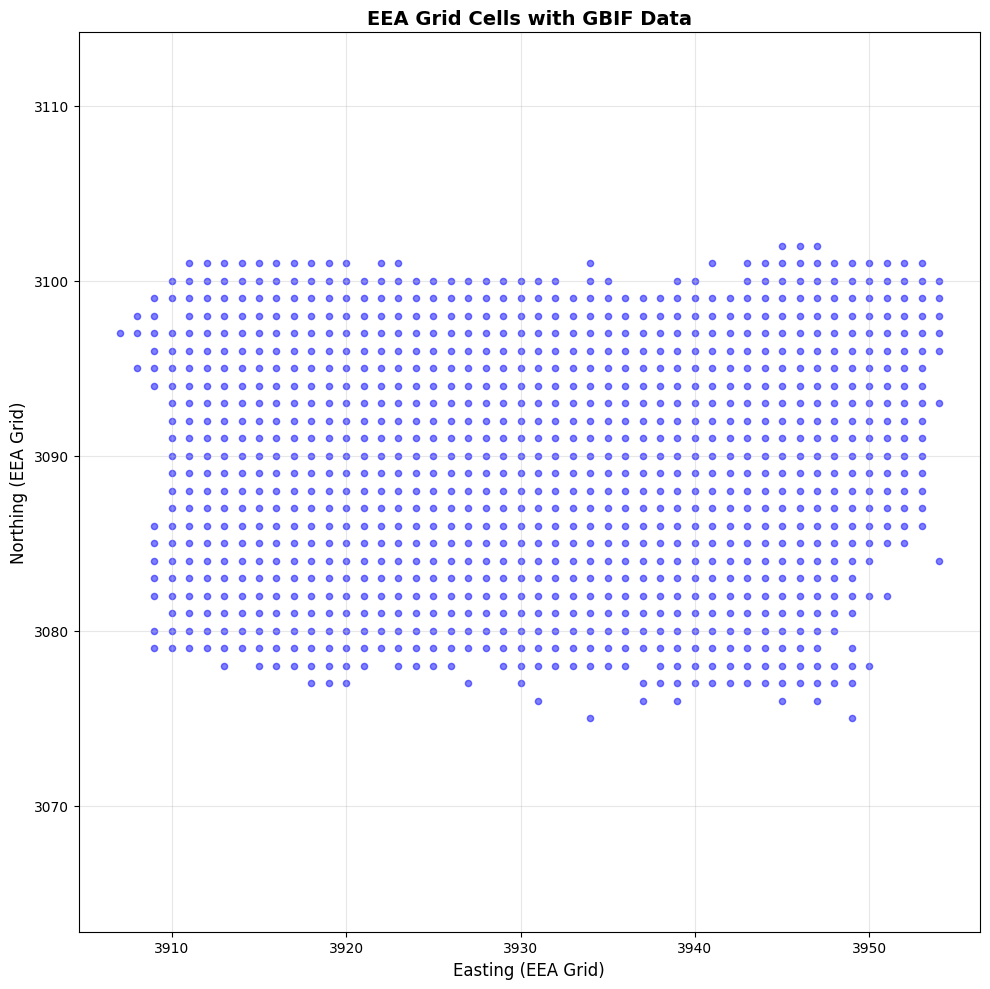


CONNECTING TO CLIMATE DATA GRID

Climate data grid:
  Latitude range: 50.690 to 50.874
  Longitude range: 4.176 to 4.742
  Grid size: 23 x 69

SPATIAL AGGREGATION EXAMPLE

Total cells with occurrences: 1047
Max occurrences in a cell: 1400
Mean occurrences per cell: 134.7

VISUALIZING OCCURRENCE DENSITY


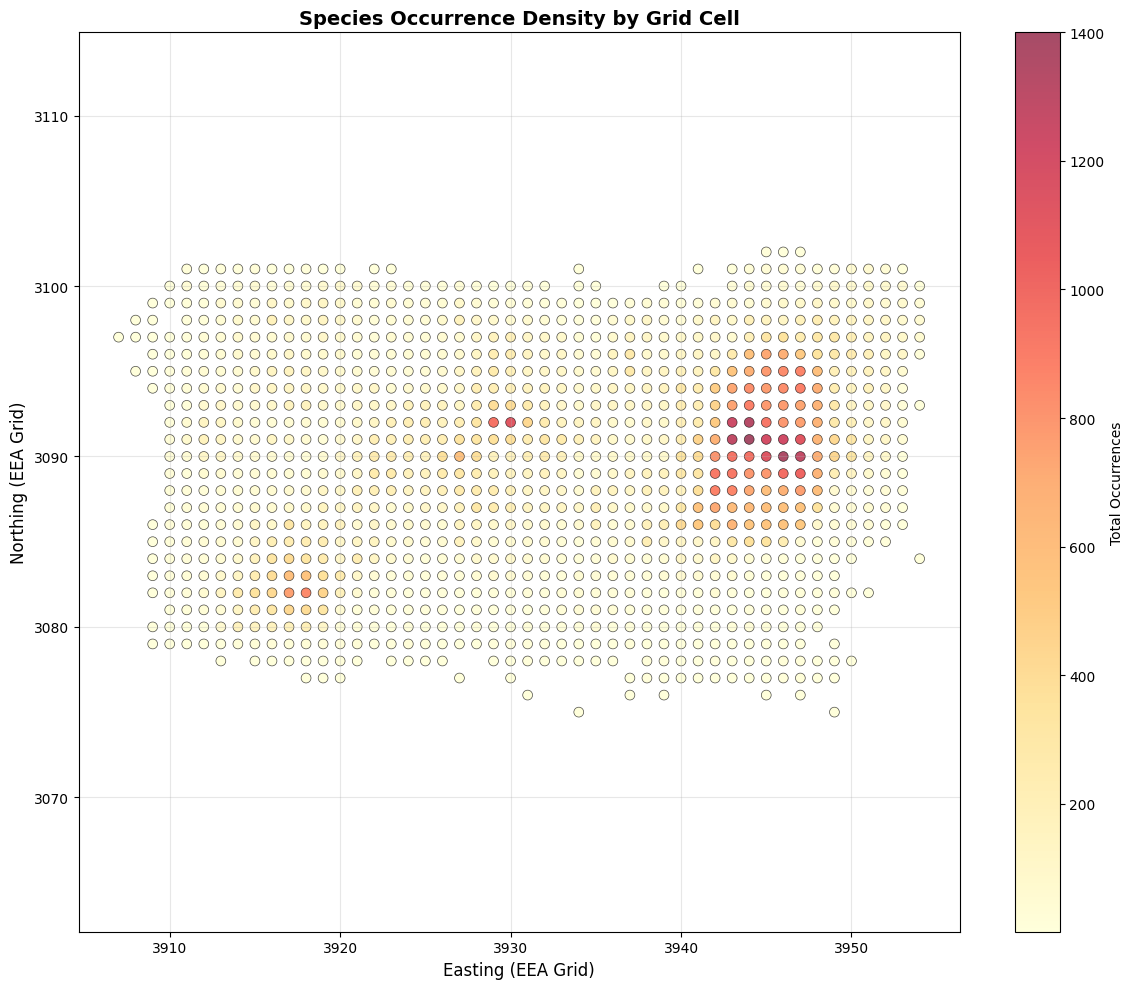


SPATIAL STRUCTURE EXPLANATION

The GBIF data uses EEA grid cells (eeacellcode) instead of direct lat/long:

1. EEA Grid System:
   - European reference grid system
   - Format: '1kmE####N####' 
   - E = Easting coordinate
   - N = Northing coordinate
   - 1km resolution cells

2. Your data:
   - Climate data: lat/long coordinates (regular grid)
   - GBIF data: EEA cell codes (1km resolution)

3. To connect them:
   - Need coordinate transformation (EEA grid → WGS84 lat/long)
   - Or spatial join/overlay operations
   - The EEA cells are likely within or overlapping your climate grid

4. The sparse matrix structure:
   - Dimensions: (specieskey, genuskey, familykey, classkey, eeacellcode, time)
   - This allows efficient storage of species x location x time data
   - Most combinations are empty (species not in that cell/time)

Recommendation:
- Use the EEA easting/northing for spatial visualization
- For analysis with climate data, you'd need to:
  a) Transform EEA coordinates to lat/l

In [3]:
from datatree import open_datatree
import matplotlib.pyplot as plt
import numpy as np
import re

# Read the NetCDF file as DataTree
file_path = 'prototype_test.nc'  # Replace with your file path

print("="*60)
print("GBIF SPATIAL STRUCTURE INVESTIGATION")
print("="*60)

# Open the DataTree
dt = open_datatree(file_path)

# Get GBIF data
gbif = dt['dynamic/gbif_occurences'].ds

print("\nGBIF Coordinates:")
print(f"  eeacellcode: {len(gbif.eeacellcode)} cells")
print(f"\nFirst 10 cell codes:")
for i in range(min(10, len(gbif.eeacellcode))):
    print(f"    {gbif.eeacellcode.values[i]}")

# ============================================
# PARSE EEA CELL CODES
# ============================================
print("\n" + "="*60)
print("PARSING EEA CELL CODES")
print("="*60)

# EEA cell codes are typically in format: '1kmE3907N3097'
# E = Easting, N = Northing in the EEA reference grid

def parse_eea_cellcode(cellcode):
    """Parse EEA cell code to extract easting and northing"""
    # Pattern: 1kmE####N####
    match = re.match(r'1kmE(\d+)N(\d+)', cellcode)
    if match:
        easting = int(match.group(1))
        northing = int(match.group(2))
        return easting, northing
    return None, None

# Parse all cell codes
eastings = []
northings = []
for cellcode in gbif.eeacellcode.values:
    e, n = parse_eea_cellcode(cellcode)
    if e is not None:
        eastings.append(e)
        northings.append(n)

eastings = np.array(eastings)
northings = np.array(northings)

print(f"\nParsed {len(eastings)} cell codes")
print(f"Easting range: {eastings.min()} to {eastings.max()}")
print(f"Northing range: {northings.min()} to {northings.max()}")

# ============================================
# VISUALIZE SPATIAL GRID
# ============================================
print("\n" + "="*60)
print("VISUALIZING SPATIAL GRID")
print("="*60)

plt.figure(figsize=(10, 10))
plt.scatter(eastings, northings, c='blue', alpha=0.5, s=20)
plt.xlabel('Easting (EEA Grid)', fontsize=12)
plt.ylabel('Northing (EEA Grid)', fontsize=12)
plt.title('EEA Grid Cells with GBIF Data', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# ============================================
# CONNECT TO LAT/LONG FROM CLIMATE DATA
# ============================================
print("\n" + "="*60)
print("CONNECTING TO CLIMATE DATA GRID")
print("="*60)

# Get lat/long from climate data
chelsa = dt['static/chelsa_clim_ref_period'].ds
lats = chelsa.lat.values
longs = chelsa.long.values

print(f"\nClimate data grid:")
print(f"  Latitude range: {lats.min():.3f} to {lats.max():.3f}")
print(f"  Longitude range: {longs.min():.3f} to {longs.max():.3f}")
print(f"  Grid size: {len(lats)} x {len(longs)}")

# Create 2D meshgrid for climate data
lon_grid, lat_grid = np.meshgrid(longs, lats)

print("\n" + "="*60)
print("SPATIAL AGGREGATION EXAMPLE")
print("="*60)

# Reconstruct occurrence data aggregated by spatial cell
coords_data = gbif['coords'].values
occurrence_values = gbif['data'].values
dims_info = gbif['dims'].values

# Get dimension indices
eeacell_idx = list(dims_info).index('eeacellcode')
time_idx = list(dims_info).index('time')

# Aggregate occurrences by cell (sum across all time)
cell_occurrences = {}
for i in range(len(occurrence_values)):
    cell_id = coords_data[eeacell_idx, i]
    if cell_id not in cell_occurrences:
        cell_occurrences[cell_id] = 0
    cell_occurrences[cell_id] += occurrence_values[i]

print(f"\nTotal cells with occurrences: {len(cell_occurrences)}")

# Create spatial map of occurrences
occurrence_map = np.zeros(len(gbif.eeacellcode))
for cell_id, count in cell_occurrences.items():
    occurrence_map[cell_id] = count

print(f"Max occurrences in a cell: {int(occurrence_map.max())}")
print(f"Mean occurrences per cell: {occurrence_map.mean():.1f}")

# ============================================
# VISUALIZE OCCURRENCE DENSITY
# ============================================
print("\n" + "="*60)
print("VISUALIZING OCCURRENCE DENSITY")
print("="*60)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(eastings, northings,
                     c=occurrence_map,
                     cmap='YlOrRd',
                     s=50,
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Total Occurrences')
plt.xlabel('Easting (EEA Grid)', fontsize=12)
plt.ylabel('Northing (EEA Grid)', fontsize=12)
plt.title('Species Occurrence Density by Grid Cell', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# ============================================
# EXPLANATION
# ============================================
print("\n" + "="*60)
print("SPATIAL STRUCTURE EXPLANATION")
print("="*60)
print("""
The GBIF data uses EEA grid cells (eeacellcode) instead of direct lat/long:

1. EEA Grid System:
   - European reference grid system
   - Format: '1kmE####N####'
   - E = Easting coordinate
   - N = Northing coordinate
   - 1km resolution cells

2. Your data:
   - Climate data: lat/long coordinates (regular grid)
   - GBIF data: EEA cell codes (1km resolution)

3. To connect them:
   - Need coordinate transformation (EEA grid → WGS84 lat/long)
   - Or spatial join/overlay operations
   - The EEA cells are likely within or overlapping your climate grid

4. The sparse matrix structure:
   - Dimensions: (specieskey, genuskey, familykey, classkey, eeacellcode, time)
   - This allows efficient storage of species x location x time data
   - Most combinations are empty (species not in that cell/time)

Recommendation:
- Use the EEA easting/northing for spatial visualization
- For analysis with climate data, you'd need to:
  a) Transform EEA coordinates to lat/long
  b) Spatially join GBIF cells to climate grid cells
  c) Aggregate occurrences to the coarser climate grid
""")

print("\n" + "="*60)
